# Feature Engineering + Outliers — Plan:
- Step 1 — Outlier Detection (MonthlyCharges, TotalCharges, LTV)
- Step 2 — Tenure Buckets (already created, refine as categorical)
- Step 3 — ARPU Tiers (Low / Medium / High revenue)
- Step 4 — Risk Flags (high risk payment method, fiber, no security, etc.)
- Step 5 — Ratio Features (Value perception metrics)
- Step 6 — Export cleaned_featured_dataset_v2.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
pd.set_option('display.max_columns', None)

## Data Load & Quick Scan

In [3]:
import kagglehub
path = kagglehub.dataset_download('blastchar/telco-customer-churn')

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


In [4]:
filename = os.listdir(path)[0]
fp = os.path.join(path, filename)

In [5]:
df = pd.read_csv(fp)

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Clean

In [9]:
missing = df.isna().sum().to_frame('missing_count')
missing['missing_pct'] = (missing['missing_count'] / len(df)) * 100
print("Missing rows:\n", missing)

Missing rows:
                   missing_count  missing_pct
customerID                    0          0.0
gender                        0          0.0
SeniorCitizen                 0          0.0
Partner                       0          0.0
Dependents                    0          0.0
tenure                        0          0.0
PhoneService                  0          0.0
MultipleLines                 0          0.0
InternetService               0          0.0
OnlineSecurity                0          0.0
OnlineBackup                  0          0.0
DeviceProtection              0          0.0
TechSupport                   0          0.0
StreamingTV                   0          0.0
StreamingMovies               0          0.0
Contract                      0          0.0
PaperlessBilling              0          0.0
PaymentMethod                 0          0.0
MonthlyCharges                0          0.0
TotalCharges                  0          0.0
Churn                         0         

In [10]:
duplicates = df.duplicated().sum()
print("Duplicate rows:\n", duplicates)

Duplicate rows:
 0


In [11]:
# Fix TotalCharges column
# print(df['TotalCharges'].dtype)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# print(df['TotalCharges'].dtype)

In [12]:
df['TotalCharges'].isna().sum() # 11

np.int64(11)

In [13]:
df = df[df['TotalCharges'].notna()].copy()

In [14]:
df['TotalCharges'].isna().sum() # 0

np.int64(0)

In [15]:
unique_vals = df.nunique()
unique_vals

,0
customerID,7032
gender,2
SeniorCitizen,2
Partner,2
Dependents,2
tenure,72
PhoneService,2
MultipleLines,3
InternetService,3
OnlineSecurity,3


In [16]:
cat_threshold = 4
low_cardinality_cols = unique_vals[unique_vals <= cat_threshold].index
print("Low Cardinality Columns:", len(low_cardinality_cols), "\n", low_cardinality_cols)

Low Cardinality Columns: 17 
 Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')


In [17]:
df[low_cardinality_cols] = df[low_cardinality_cols].astype('category')
df.dtypes

,0
customerID,object
gender,category
SeniorCitizen,category
Partner,category
Dependents,category
tenure,int64
PhoneService,category
MultipleLines,category
InternetService,category
OnlineSecurity,category


In [18]:
internet_related_cols = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]
for col in internet_related_cols:
  df[col] = df[col].replace({'No internet service': 'No'})

df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})

/tmp/ipython-input-4094404887.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[col] = df[col].replace({'No internet service': 'No'})
/tmp/ipython-input-4094404887.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})


In [19]:
for col in internet_related_cols + ['MultipleLines']:
  print(col, df[col].nunique())

OnlineSecurity 2
OnlineBackup 2
DeviceProtection 2
TechSupport 2
StreamingTV 2
StreamingMovies 2
MultipleLines 2


In [20]:
# final validation
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [21]:
# export cleaned dataset
os.makedirs("data", exist_ok=True)
df.to_csv("data/cleaned_dataset_v1.csv", index=False)

## Data Analysis
- Basic Churn Summary
- Churn by Demographics (The Person / User attributes)
- Churn by Subscription / Services (The Product / Usage attributes)
- Churn by Account (The Relationship / Administrative attributes)
- Tenure Segmentation (cohort-style buckets/bins)

In [22]:
# Basic Churn Summary

churn_summary = df['Churn'].value_counts().to_frame('count')
# churn_summary
churn_summary['percent'] = round((churn_summary['count'] / len(df)) * 100, 2)
churn_summary

,count,percent
Churn,,
No,5163,73.42
Yes,1869,26.58


In [23]:
# Churn by Demographics

demographic_cols = ['gender', 'SeniorCitizen', 'Dependents']

demographic_churn = {}

for col in demographic_cols:
  table = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
  demographic_churn[col] = table
  print(f"*** {col} vs Churn (%) ***\n{table}\n")

*** gender vs Churn (%) ***
Churn          No        Yes
gender                      
Female  73.040482  26.959518
Male    73.795435  26.204565

*** SeniorCitizen vs Churn (%) ***
Churn                 No        Yes
SeniorCitizen                      
0              76.349745  23.650255
1              58.318739  41.681261

*** Dependents vs Churn (%) ***
Churn              No        Yes
Dependents                      
No          68.720860  31.279140
Yes         84.468795  15.531205



Observations:
- gender -> no effect
- senior citizens -> very high churn (2x)
- dependents:
  - with -> low churn
  - without -> high churn (2x)

In [24]:
# Churn by Subscription / Services

service_cols = [
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

service_churn = {}

for col in service_cols:
  table = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
  service_churn[col] = table
  print(f"*** {col} vs Churn (%) ***\n{table}\n")

*** PhoneService vs Churn (%) ***
Churn                No        Yes
PhoneService                      
No            75.000000  25.000000
Yes           73.252519  26.747481

*** MultipleLines vs Churn (%) ***
Churn                 No        Yes
MultipleLines                      
No             74.932349  25.067651
Yes            71.351534  28.648466

*** InternetService vs Churn (%) ***
Churn                   No        Yes
InternetService                      
DSL              81.001656  18.998344
Fiber optic      58.107235  41.892765
No               92.565789   7.434211

*** OnlineSecurity vs Churn (%) ***
Churn                  No        Yes
OnlineSecurity                      
No              68.626669  31.373331
Yes             85.359801  14.640199

*** OnlineBackup vs Churn (%) ***
Churn               No       Yes
OnlineBackup                    
No            70.78359  29.21641
Yes           78.43299  21.56701

*** DeviceProtection vs Churn (%) ***
Churn                    No

Observations:
- Fiber-optic customers -> very high churn
- Streaming -> high churn
- Other Services:
  - with -> low churn
  - without -> high churn

In [25]:
# Churn by Account

account_cols = ['Contract', 'PaymentMethod']

account_churn = {}

for col in account_cols:
  table = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
  account_churn[col] = table
  print(f"*** {col} vs Churn (%) ***\n{table}\n")

*** Contract vs Churn (%) ***
Churn                  No        Yes
Contract                            
Month-to-month  57.290323  42.709677
One year        88.722826  11.277174
Two year        97.151335   2.848665

*** PaymentMethod vs Churn (%) ***
Churn                             No        Yes
PaymentMethod                                  
Bank transfer (automatic)  83.268482  16.731518
Credit card (automatic)    84.746877  15.253123
Electronic check           54.714588  45.285412
Mailed check               80.798005  19.201995



Observations:
- Month-to-month -> very high churn
- Electronic check -> very high churn

In [26]:
# Tenure Segmentation (cohort-style buckets/bins)
bins = [x for x in range(0, 73, 12)]

labels = ['0-12', '13-24', '25-36', '37-48', '49-60', '61-72']

df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

In [27]:
tenure_churn = pd.crosstab(df['tenure_group'], df['Churn'], normalize='index') * 100
tenure_churn

Churn,No,Yes
tenure_group,,
0-12,52.321839,47.678161
13-24,71.289062,28.710938
25-36,78.365385,21.634615
37-48,80.971129,19.028871
49-60,85.576923,14.423077
61-72,93.390192,6.609808


Observations:
- new customers (0-12 months) -> very high churn
- old/long-term customers (61-72 months) -> lowest churn

In [28]:
# Revenue Metrics
# ARPU by Churn: average monthly revenue (churner vs non-churner)
arpu_summary = round(df.groupby('Churn')['MonthlyCharges'].mean(), 2)
arpu_summary

/tmp/ipython-input-1972069562.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  arpu_summary = round(df.groupby('Churn')['MonthlyCharges'].mean(), 2)


,MonthlyCharges
Churn,
No,61.31
Yes,74.44


In [29]:
# Lifetime Value by Churn

df['LTV'] = df['MonthlyCharges'] * df['tenure']

ltv_summary = round(df.groupby('Churn')['LTV'].mean(), 2)
ltv_summary

/tmp/ipython-input-4059621002.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ltv_summary = round(df.groupby('Churn')['LTV'].mean(), 2)


,LTV
Churn,
No,2555.20
Yes,1531.61


In [30]:
# ARPU by contract type

arpu_by_contract = round(df.groupby('Contract')['MonthlyCharges'].mean(), 2)
arpu_by_contract

/tmp/ipython-input-585547525.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  arpu_by_contract = round(df.groupby('Contract')['MonthlyCharges'].mean(), 2)


,MonthlyCharges
Contract,
Month-to-month,66.40
One year,65.08
Two year,60.87


Observations:
- Customers who pay more churn more, but also generate less lifetime value -> not loyal, high ARPU, low LTV
- Customers who stay loyal, pay less each month (~5.5 per user per month compared to monthly customers), but generate high lifetime value -> loyal, low ARPU, high LTV
- Month-to-month customers pay more, but also churn most

## Feature Engineering & Outlier Detection

### Step 1 — Outlier Detection (MonthlyCharges, TotalCharges, LTV)

In [31]:
num_cols = ['MonthlyCharges', 'TotalCharges', 'LTV']

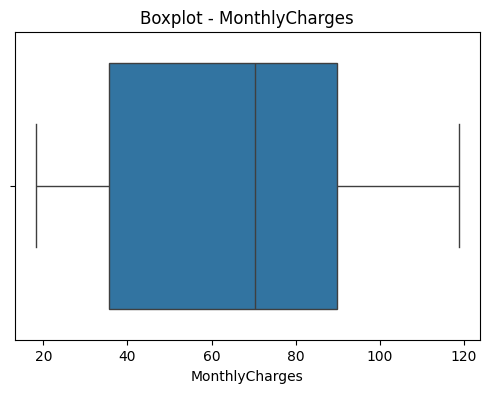

MonthlyCharges: Lower=-45.824999999999996, Upper:171.27499999999998
Outliers Count: 0


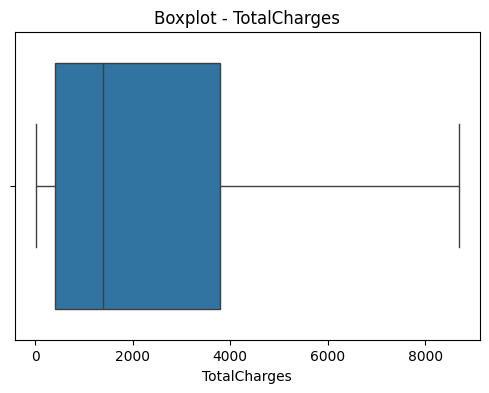

TotalCharges: Lower=-4688.481250000001, Upper:8884.66875
Outliers Count: 0


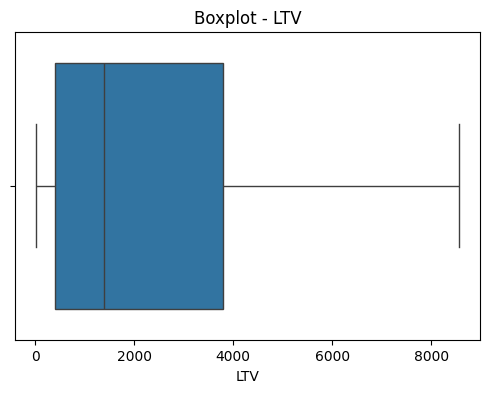

LTV: Lower=-4692.374999999999, Upper:8881.425
Outliers Count: 0


In [32]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot - {col}")
    plt.show()

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr

    print(f"{col}: Lower={lower}, Upper:{upper}")
    print(f"Outliers Count: {df[(df[col] < lower) | (df[col] > upper)].shape[0]}")

### Step 2 — Tenure Buckets (categorical feature)

In [33]:
# df['tenure_group'].unique()
df['tenure_group'] = df['tenure_group'].astype('category')
df['tenure_group'] = df['tenure_group'].cat.reorder_categories(['0-12','13-24','25-36','37-48','49-60','61-72'], ordered=True)

df['tenure_group'].value_counts()

,count
tenure_group,
0-12,2175
61-72,1407
13-24,1024
25-36,832
49-60,832
37-48,762


`reorder_categories` is Necessary to establish an **Ordinal Relationship** among the tenure groups.

| Key | Explanation |
| --- | --- |
| Ordinal Data: | Tenure groups (0-12, 13-24, etc.) have an inherent rank or order. 13-24 is unambiguously greater than 0-12 |
| Pandas Default: | When pd.cut creates the categories, it sets the `ordered=True` flag for the categories **by default**. However, when you then run `.astype('category')`, the resulting categories might sometimes lose this ordering or adopt an alphabetical/lexicographical order if not explicitly set |
| Explicit Ordering: | Running reorder_categories **explicitly confirms and enforces** the correct sequential order you define, ensuring Pandas and subsequent machine learning libraries (especially those that process ordered data, like decision trees or certain forms of encoding) correctly interpret that the category 61-72 is "higher" than 0-12 |
| Model Stability: | It makes the feature stable and clean for modeling. Although many models (like One-Hot Encoding) ignore order, explicitly defining the ordinal nature protects against inconsistent behavior and is essential if you use Ordinal Encoding |

### Step 3 — ARPU Tiers (Low / Medium / High revenue)
- create revenue tiers using quantiles
- 3-level segmentation, useful for EDA & ML

In [34]:
# Quantile-based discretization function

df['ARPU_tier'] = pd.qcut(df['MonthlyCharges'], q=3, labels=['Low', 'Medium', 'High'])

df['ARPU_tier'] = df['ARPU_tier'].astype('category')

df['ARPU_tier'].value_counts()

,count
ARPU_tier,
Low,2345
Medium,2345
High,2342


### Step 4 — Risk Flags (high risk payment method, fiber, no security, etc.)
- convert the strongest churn predictors into direct risk flags.

In [35]:
# High-risk payment (electronic check users)

df['is_electronic_check'] = (df['PaymentMethod'] == 'Electronic check').astype(int)

df['is_electronic_check'].value_counts()

,count
is_electronic_check,
0,4667
1,2365


In [36]:
# High-risk contract type (month-to-month)

df['is_monthly_contract'] = (df['Contract'] == 'Month-to-month').astype('int')

df['is_monthly_contract'].value_counts()

,count
is_monthly_contract,
1,3875
0,3157


In [37]:
# High-risk internet service (Fiber optic)

df['is_fiber'] = (df['InternetService'] == 'Fiber optic').astype('int')

df['is_fiber'].value_counts()

,count
is_fiber,
0,3936
1,3096


In [38]:
# Missing protection services

df['no_tech_support'] = (df['TechSupport'] == 'No').astype('int')
df['no_online_security'] = (df['OnlineSecurity'] == 'No').astype('int')
df['no_device_protection'] = (df['DeviceProtection'] == 'No').astype('int')

In [39]:
# Senior citizen risk flag (strong demographic predictor)

df['is_senior'] = (df['SeniorCitizen'] == 1).astype('int')
df['is_senior'].value_counts()

,count
is_senior,
0,5890
1,1142


### Step 5 — Ratio Features (Value-Perception Metrics)
- These features help measure whether customers perceive good value

In [ ]:
# Cost per month of tenure (stability indicator) — historical average

df['avg_cost_per_month'] = df['TotalCharges'] / df['tenure'].replace(0, 1)

In [41]:
# Protection-to-cost ratio (expected value indicator)

df['security_to_cost_ratio'] = df['no_online_security'] / df['MonthlyCharges']

`security_to_cost_ratio` highlights churn risk:

- higher ratio = low-cost, unprotected customers (highest churn tendency)
- low ratio = high-cost but unprotected (still risky)
- 0 ratio = customers with security (low risk)

Helps model detect vulnerable, poor-value customers.


In [42]:
# Contract value proxy (monthly charges × contract length assumption)

contract_map = {
    'Month-to-month': 1,
    'One year': 12,
    'Two year': 3
}

df['contract_length'] = df['Contract'].map(contract_map)
# CONVERT TO INT, else below line throws a TypeError: Object with dtype category cannot perform the numpy op multiply
df['contract_length'] = df['contract_length'].astype('int')

df['contract_value_proxy'] = df['MonthlyCharges'] * df['contract_length']

This helps identify:
- high-value short-term customers
- long-term low-value customers
- mispriced segments

### Step 6 — Export cleaned_featured_dataset_v2.csv

In [43]:
# Final Validation

print(f"{df.shape}\n{'*** ' * 10}\n{df.head(3)}\n{'*** ' * 10}\n{list(df.columns)}")

(7032, 35)
*** *** *** *** *** *** *** *** *** *** 
   customerID  gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female             0     Yes         No       1           No   
1  5575-GNVDE    Male             0      No         No      34          Yes   
2  3668-QPYBK    Male             0      No         No       2          Yes   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL             No          Yes               No   
1            No             DSL            Yes           No              Yes   
2            No             DSL            Yes          Yes               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes  

In [44]:
os.makedirs("data", exist_ok=True)
df.to_csv("data/cleaned_featured_dataset_v2.csv", index=False)